In [1]:
import pydicom
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def load_dicom_image(path, img_size=256):
    # Load dicom and convert to 256x256 RGB image
    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array
    image = Image.fromarray(image).convert('RGB')
    image = image.resize((img_size, img_size))
    return np.array(image) / 255.0

    # Convert to TensorFlow tensor
    return tf.convert_to_tensor(image, dtype=tf.float32)


In [3]:
def process_patient_images(patient_folder, img_size=256):
    images = []
    if not os.listdir(patient_folder):  # Check if the folder is empty
        logging.warning(f"No files found in {patient_folder}. Skipping this folder.")
        return images
    for filename in os.listdir(patient_folder):
        if filename.endswith('.dcm'):
            path = os.path.join(patient_folder, filename)
            image = load_dicom_image(path, img_size=img_size)
            images.append(image)
    
    return images  # Return the list of processed images

In [4]:
def find_patient_folders(root_directory):

    patient_folders = []
    for dirpath, dirnames, filenames in os.walk(root_directory):
        if filenames:  # Simple check to ensure the directory contains files (e.g., .dcm files)
            patient_folders.append(dirpath)
    return patient_folders

# Specify the path to your dataset root directory
dataset_root = '/path/to/your/dataset'

# Find all patient folders within the dataset root directory
patient_folders = find_patient_folders(dataset_root)

# Process images for all patients
all_images = []
for folder in patient_folders:
    patient_images = process_patient_images(folder)
    all_images.extend(patient_images)  # Combine images from all patients into a single list

# Further processing can be done here, such as splitting data into training/validation sets, etc.
# For demonstration, simply print the number of processed images
print(f"Processed {len(all_images)} images from {len(patient_folders)} patient folders.")

Processed 0 images from 0 patient folders.


In [5]:
def create_datasets(root_dir, img_size=256, batch_size=32, val_split=0.15, test_split=0.15):
    all_images = []
    all_labels = []

    patient_folders = []
    for condition in os.listdir(root_dir):
        condition_path = os.path.join(root_dir, condition)
        if not os.path.isdir(condition_path):
            continue
        label = 1 if condition.lower() == 'cancer' else 0
        for patient_folder_name in os.listdir(condition_path):
            patient_folder_path = os.path.join(condition_path, patient_folder_name)
            if os.path.isdir(patient_folder_path):
                patient_folders.append((patient_folder_path, label))
                logging.info(f"Added folder {patient_folder_path} with label {label}")
    
    # Split patient folders into training, validation, and test sets
    initial_split = 1 - (val_split + test_split)
    train_folders, temp_folders = train_test_split(patient_folders, test_size=(val_split + test_split), random_state=42)
    val_folders, test_folders = train_test_split(temp_folders, test_size=test_split/(val_split + test_split), random_state=42)

    train_dataset = process_data(train_folders, img_size, batch_size)
    val_dataset = process_data(val_folders, img_size, batch_size)
    test_dataset = process_data(test_folders, img_size, batch_size)
    
    return train_dataset, val_dataset, test_dataset


In [6]:
def process_data(folders, img_size, batch_size):
    all_images = []
    all_labels = []
    for folder_path, label in folders:
        images = process_patient_images(folder_path, img_size=img_size)
        all_images.extend(images)
        all_labels.extend([label] * len(images))
    
    dataset_images = tf.stack(all_images)
    dataset_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((dataset_images, dataset_labels)).shuffle(buffer_size=1024).batch(batch_size)
    return dataset

In [5]:
""" def create_dataset(root_dir, img_size=256, batch_size=32):
    # Placeholder lists for images and labels
    all_images = []
    all_labels = []
    
    # Navigate through the root directory and process each patient's images
    for condition in os.listdir(root_dir):
        condition_path = os.path.join(root_dir, condition)
        if not os.path.isdir(condition_path):
            continue
        
        label = 1 if condition.lower() == 'cancer' else 0
        
        for patient_folder_name in os.listdir(condition_path):
            patient_folder_path = os.path.join(condition_path, patient_folder_name)
            if not os.path.isdir(patient_folder_path):
                continue
            
            representative_image = process_patient_images(patient_folder_path, img_size=img_size)
            if representative_image is not None:
                all_images.append(representative_image)
                all_labels.append(label)
    
    # Convert lists to tensors
    dataset_images = tf.stack(all_images)
    dataset_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    
    # Create a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dataset_images, dataset_labels))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    return dataset """

In [5]:
""" from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_model(input_shape=(256, 256, 3), dropout_rate=0.5, l2_reg=0.001):
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid',kernel_regularizer=l2(l2_reg))
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
 """

In [7]:
""" from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_model_with_resnet(input_shape=(256, 256, 3), dropout_rate=0.5, l2_reg=0.001):
    base_model = ResNet50(input_shape=input_shape,
                          include_top=False,
                          weights='imagenet')
    base_model.trainable = False  

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
 """

In [7]:
# train_dataset = create_dataset('/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/CapstoneData', img_size=256, batch_size=32)
train_dataset, val_dataset, test_dataset = create_datasets(root_dir='/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data', img_size=256, batch_size=32)

2024-04-15 19:51:37,750 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_1434_non_cancer with label 0
2024-04-15 19:51:37,751 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_692_non_cancer with label 0
2024-04-15 19:51:37,751 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_1356_non_cancer with label 0
2024-04-15 19:51:37,751 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_6593_non_cancer with label 0
2024-04-15 19:51:37,752 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_4656_non_cancer with label 0
2024-04-15 19:51:37,752 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_5155_non_cancer with label 0
2024-

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),  # Adjust based on your image size
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification, 'softmax' for multi-class
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-15 19:50:27.019415: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-15 19:50:27.019437: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-04-15 19:50:27.019440: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-04-15 19:50:27.019453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 19:50:27.019464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device 

In [3]:
# Assuming you have your datasets ready as train_dataset and val_dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,             # Number of epochs to train for
    batch_size=32,         # Size of the batches of data (optional, depending on your data loader)
    verbose=1              # Show training log
)


NameError: name 'train_dataset' is not defined

In [8]:
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_model(hp):
    input_shape = (256, 256, 3)
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    l2_reg = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    loss_function = hp.Choice('loss_function', ['binary_crossentropy', 'hinge'])

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=loss_function,
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

    return model

In [9]:
def tuner_search(train_dataset, val_dataset):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='my_dir',
        project_name='intro_to_kt'
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[stop_early])

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete. The optimal dropout rate is {best_hps.get('dropout_rate')},
    the optimal L2 regularization is {best_hps.get('l2_reg')},
    the optimal learning rate is {best_hps.get('learning_rate')},
    and the optimal loss function is {best_hps.get('loss_function')}.
    """)

    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)
    
    return model, history


In [10]:
""" model = build_model_with_resnet()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Or another appropriate loss function
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]) """

In [10]:
# Calling the tuner_search function with the training and validation datasets
model, history = tuner_search(train_dataset, val_dataset)

# After tuning and training, evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Trial 1 Complete [00h 03m 19s]
val_accuracy: 0.6219382286071777

Best val_accuracy So Far: 0.6219382286071777
Total elapsed time: 00h 03m 19s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
0.4               |0.2               |dropout_rate
0.0099719         |0.0085163         |l2_reg
0.0085015         |0.0011324         |learning_rate
hinge             |binary_crossent...|loss_function

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.6202 - auc: 0.4993 - loss: 1.0121 - precision: 0.4668 - recall: 0.0454 - val_accuracy: 0.6177 - val_auc: 0.5000 - val_loss: 1.0008 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.6204 - auc: 0.5023 - loss: 1.0008 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6177 - val_auc: 0.5000 - val_loss: 1.0007 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accura

KeyboardInterrupt: 

In [ ]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset) 

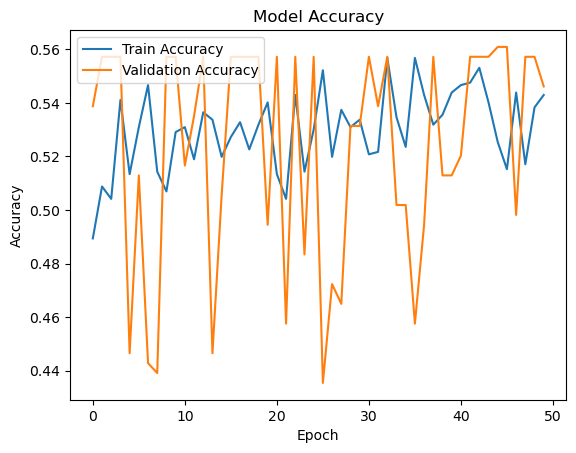

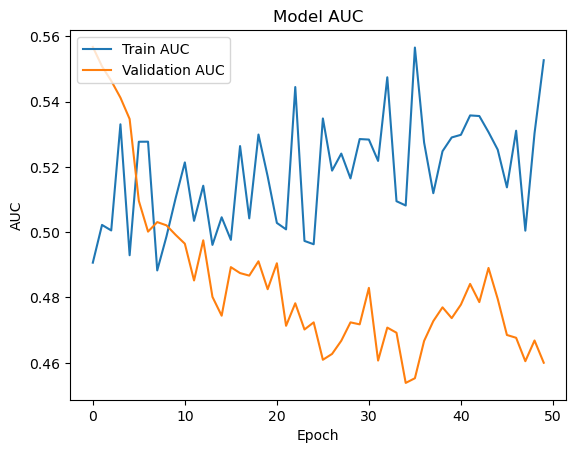

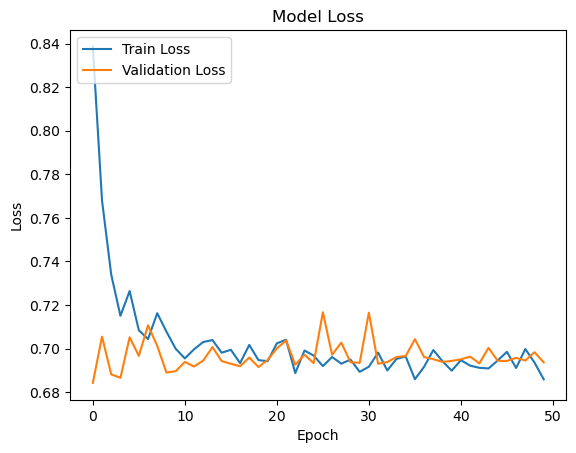

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation AUC values
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')  
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [3]:
# dicom_dir_path = '/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/CapstoneData'  # Directory where DICOM files are stored

tensor([1.], device='mps:0')
